# Assignment4 - Question 1  (Alejandro Akifarry - 301-195-788)
---

## Imports

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.ndimage import rotate

---

## 1. Retrieve and load the Olivetti faces dataset

In [58]:
olivetti_faces = fetch_olivetti_faces()
X = olivetti_faces.data
y = olivetti_faces.target
images = olivetti_faces.images # 64x64 version of .data
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


---

## 2. Split the dataset into training, validation, and test sets using stratified sampling to ensure that each set contains the same number of images per person.

In [59]:
'''
Split is:
80% train
10% validation
10% test
to ensure we have a lot of data to train, 
and also still have some left for validation and testing
'''
# First split into train + validation (90%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

# Now split the train + validation set (90%) into train (80%) and validation (10%)
# 10/90 = 0.1111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val)

In [60]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(320, 4096)
(40, 4096)
(40, 4096)
(320,)
(40,)
(40,)


---

## 3. Apply PCA on the training data, preserving 99% of the variance, to reduce the dataset’s dimensionality. 

In [61]:
pca = PCA(n_components=0.99)

X_train_reduced = pca.fit_transform(X_train)

In [62]:
print(X_train_reduced.shape)
print(y_train.shape)

(320, 222)
(320,)


---

## 4. Determine the most suitable covariance type for the dataset.

In [63]:
covariance_types = ["spherical", "diag", "tied", "full"]

aic_scores_4 = []
bic_scores_4 = []
n_components = 20
n_inits = 10

for c_type in covariance_types:
    gm = GaussianMixture(
        n_components=n_components,
        covariance_type=c_type,
        n_init=n_inits,
        random_state=42)
    gm.fit(X_train_reduced)

    # Get scores
    aic = gm.aic(X_train_reduced)
    bic = gm.bic(X_train_reduced)

    # Collect scores
    aic_scores_4.append(aic)
    bic_scores_4.append(bic)

    print(f"Covariance type: {c_type}; AIC: {aic}; BIC: {bic}")

# Find the best covariance type
best_cov_aic = covariance_types[aic_scores_4.index(min(aic_scores_4))]
best_cov_bic = covariance_types[bic_scores_4.index(min(bic_scores_4))]

print(f"Best covariance type by AIC: {best_cov_aic}")
print(f"Best covariance type by BIC: {best_cov_bic}")

Covariance type: spherical; AIC: 85311.81759746141; BIC: 102190.12733762171
Covariance type: diag; AIC: 19424.677210327485; BIC: 52958.96575189626
Covariance type: tied; AIC: 56020.61259360573; BIC: 166100.8055227334
Covariance type: full; AIC: 237278.74996897508; BIC: 2119626.6854668846
Best covariance type by AIC: diag
Best covariance type by BIC: diag


---

## 5. Determine the minimum number of clusters that best represent the dataset using either AIC or BIC. 

In [64]:
covariance_type = "diag"
n_components_range = range(1, 21)
n_inits = 10
aic_scores_5 = []
bic_scores_5 = []

for i in n_components_range:
    gm = GaussianMixture(
        n_components=i,
        covariance_type=covariance_type,
        n_init=n_inits,
        random_state=42)
    gm.fit(X_train_reduced)

    # Get scores
    aic = gm.aic(X_train_reduced)
    bic = gm.bic(X_train_reduced)

    # Collect scores
    aic_scores_5.append(aic)
    bic_scores_5.append(bic)

    print(f"# of cluster: {i}; AIC: {aic}; BIC: {bic}")

# Find the best number of cluster
best_n_aic = n_components_range[aic_scores_5.index(min(aic_scores_5))]
best_n_bic = n_components_range[bic_scores_5.index(min(bic_scores_5))]

print(f"Best # of clusters by AIC: {best_n_aic}")
print(f"Best # of clusters by BIC: {best_n_bic}")

# of cluster: 1; AIC: 16442.472390572664; BIC: 18115.606912705098
# of cluster: 2; AIC: 14650.75949682529; BIC: 18000.796862085954
# of cluster: 3; AIC: 14340.22276843553; BIC: 19367.16297682442
# of cluster: 4; AIC: 14768.83880564405; BIC: 21472.681857161173
# of cluster: 5; AIC: 14813.145032443414; BIC: 23193.89092708876
# of cluster: 6; AIC: 15425.5876472313; BIC: 25483.23638500488
# of cluster: 7; AIC: 15656.843033303801; BIC: 27391.39461420561
# of cluster: 8; AIC: 15974.696099897166; BIC: 29386.1505239272
# of cluster: 9; AIC: 16351.891886554706; BIC: 31440.249153712968
# of cluster: 10; AIC: 16256.175629226498; BIC: 33021.43573951299
# of cluster: 11; AIC: 17309.97875502138; BIC: 35752.1417084361
# of cluster: 12; AIC: 17516.2595375869; BIC: 37635.32533412985
# of cluster: 13; AIC: 17349.353600438342; BIC: 39145.32224010952
# of cluster: 14; AIC: 17941.195266859504; BIC: 41414.06674965891
# of cluster: 15; AIC: 18601.12795074337; BIC: 43750.902276671
# of cluster: 16; AIC: 18218

---

## 6. Plot the results from steps 3, 4, and 5.

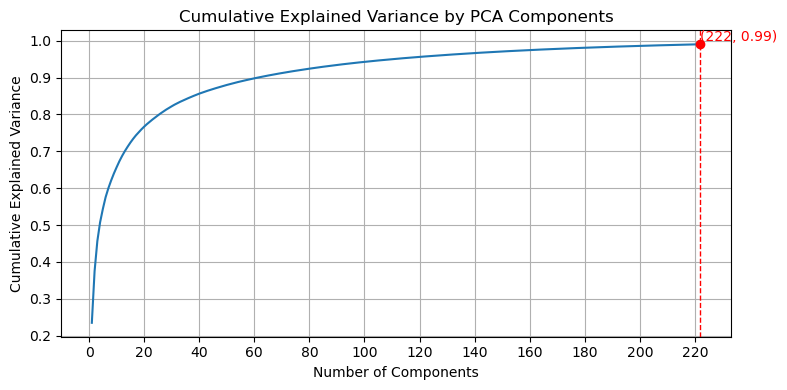

In [65]:
# Step 3 results
cumulative_variance = pca.explained_variance_ratio_.cumsum()
max_x = X_train_reduced.shape[1]
max_y = cumulative_variance[max_x - 1]

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')

# Highlight the highest point
plt.plot(max_x, max_y, 'ro')  # 'ro' makes it a red dot
plt.text(max_x, max_y, f'({max_x}, {max_y:.2f})', ha='left', va='bottom', color='red')

# Add a vertical dotted line
plt.axvline(x=max_x, color='red', linestyle='--', linewidth=1)

# Set x-axis ticks at intervals of 20
plt.xticks(range(0, len(cumulative_variance) + 1, 20))

plt.grid(True)
plt.tight_layout()
plt.show()

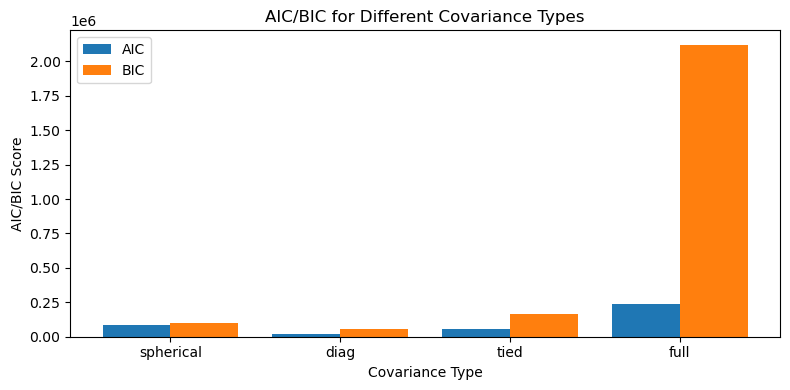

In [66]:
# Step 4 results
plt.figure(figsize=(8, 4))

x_axis_4 = np.arange(len(covariance_types))
plt.bar(x_axis_4 - 0.2, aic_scores_4, 0.4, label="AIC")
plt.bar(x_axis_4 + 0.2, bic_scores_4, 0.4, label="BIC")
plt.xticks(x_axis_4, covariance_types)
plt.xlabel('Covariance Type')
plt.ylabel('AIC/BIC Score')
plt.title('AIC/BIC for Different Covariance Types')
plt.legend()

plt.tight_layout()
plt.show()

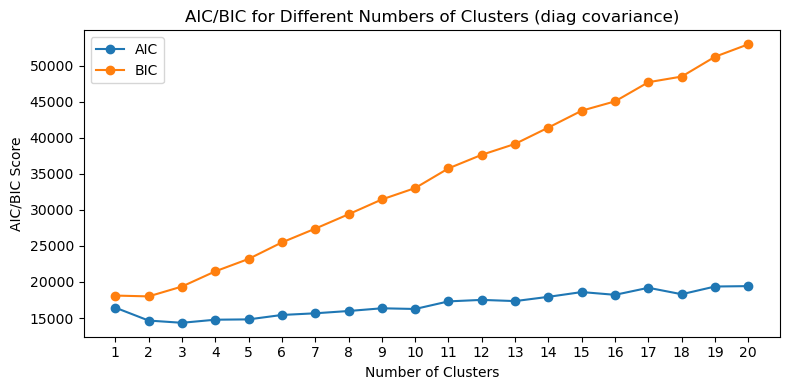

In [67]:
# Step 5 results
plt.figure(figsize=(8, 4))

plt.plot(n_components_range, aic_scores_5, label='AIC', marker='o')
plt.plot(n_components_range, bic_scores_5, label='BIC', marker='o')
plt.xticks(n_components_range)
plt.xlabel('Number of Clusters')
plt.ylabel('AIC/BIC Score')
plt.title(f'AIC/BIC for Different Numbers of Clusters (diag covariance)')
plt.legend()

plt.tight_layout()
plt.show()

---

## 7. Output the hard clustering assignments for each instance to identify which cluster each image belongs to.

In [68]:
# Using parameters from above
n_components = 2 # from BIC
covariance_type = "diag"
n_inits = 10

gm = GaussianMixture(
    n_components=n_components,
    covariance_type=covariance_type,
    n_init=n_inits,
    random_state=42)
gm.fit(X_train_reduced)

y_train_hard = gm.predict(X_train_reduced)
print(y_train_hard)

counts = np.bincount(y_train_hard)
print(f"Count of 0s: {counts[0]}")
print(f"Count of 1s: {counts[1]}")

[1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0
 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0
 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1
 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1
 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1
 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1
 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0
 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1]
Count of 0s: 169
Count of 1s: 151


In [69]:
y_train_hard.shape

(320,)

---

## 8. Output the soft clustering probabilities for each instance to show the likelihood of each image belonging to each cluster.

In [70]:
soft_clustering_probabilities = gm.predict_proba(X_train_reduced)

# 3 columns, each column is the likelihood of the image being in a cluster
print(soft_clustering_probabilities)

[[1.24441120e-10 1.00000000e+00]
 [1.00000000e+00 7.71195714e-12]
 [9.99999996e-01 4.33882360e-09]
 [1.00000000e+00 1.74562269e-12]
 [2.11294805e-17 1.00000000e+00]
 [9.99999988e-01 1.22942143e-08]
 [1.00000000e+00 4.99965945e-11]
 [9.94038092e-01 5.96190840e-03]
 [9.99942859e-01 5.71409018e-05]
 [3.11005036e-05 9.99968899e-01]
 [6.60507550e-15 1.00000000e+00]
 [9.99999992e-01 8.33529250e-09]
 [9.92692367e-01 7.30763328e-03]
 [8.67372837e-11 1.00000000e+00]
 [1.00000000e+00 1.33489040e-13]
 [2.14425446e-17 1.00000000e+00]
 [2.31562957e-05 9.99976844e-01]
 [2.70004964e-06 9.99997300e-01]
 [2.01878093e-07 9.99999798e-01]
 [9.99997387e-01 2.61293846e-06]
 [1.66575533e-06 9.99998334e-01]
 [9.99824742e-01 1.75257789e-04]
 [9.99999999e-01 5.85317593e-10]
 [9.98686781e-01 1.31321875e-03]
 [2.26899617e-03 9.97731004e-01]
 [1.00000000e+00 4.21946227e-14]
 [9.99999978e-01 2.23760854e-08]
 [4.96625756e-19 1.00000000e+00]
 [1.91491968e-07 9.99999809e-01]
 [3.57972227e-17 1.00000000e+00]
 [8.425657

In [71]:
soft_clustering_probabilities.shape

(320, 2)

---

## 9. Use the model to generate some new faces (using the sample() method) and visualize them (use the inverse_transform() method to transform the data back to its original space based on the PCA method used).

In [72]:
X_new_reduced, y_new_reduced = gm.sample(5)
print("Generated new points:\n", X_new_reduced)
print("Generated new labels:\n", y_new_reduced)

Generated new points:
 [[-4.65957254e+00  8.59498443e-01  9.27101988e-01 ... -1.24181705e-01
  -6.79706666e-03 -6.73988843e-02]
 [-7.54178380e+00  9.75317039e-01 -7.21884557e-01 ... -5.15239643e-02
  -5.84673591e-02 -5.97966708e-02]
 [-3.39706575e+00 -1.78826483e+00 -3.14590574e+00 ... -4.27846601e-02
  -2.07910839e-02  6.95160147e-02]
 [ 3.53285847e+00 -4.69419693e+00 -1.25858206e+00 ...  1.80984550e-02
   8.47848630e-02 -1.43862806e-01]
 [ 6.40776087e+00  8.89227214e-01  4.13300938e-01 ...  1.69026289e-01
  -8.28377512e-02  2.95475929e-02]]
Generated new labels:
 [0 0 0 1 1]


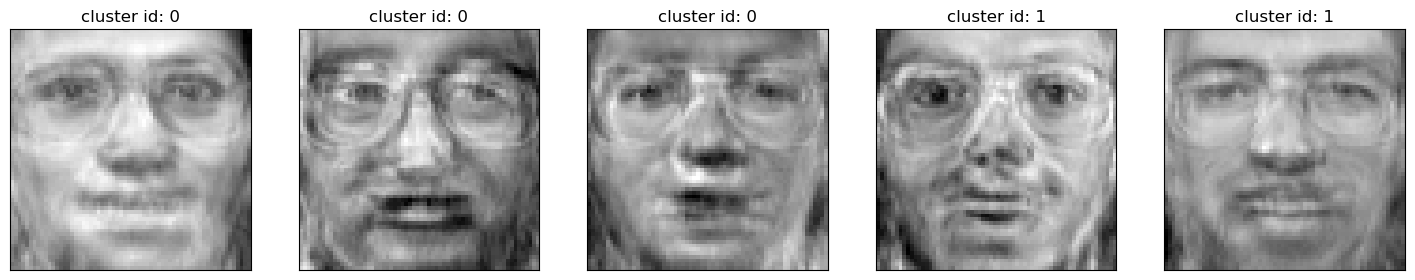

In [73]:
X_new_original = pca.inverse_transform(X_new_reduced)

fig, axarr = plt.subplots(nrows=1, ncols=5, figsize=(18,9))
axarr = axarr.flatten()
for i in range(5):
    axarr[i].imshow(X_new_original[i].reshape(64, 64), cmap='gray')
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title(f"cluster id: {y_new_reduced[i]}")

---

## 10. Modify some images (e.g., rotate, flip, darken).

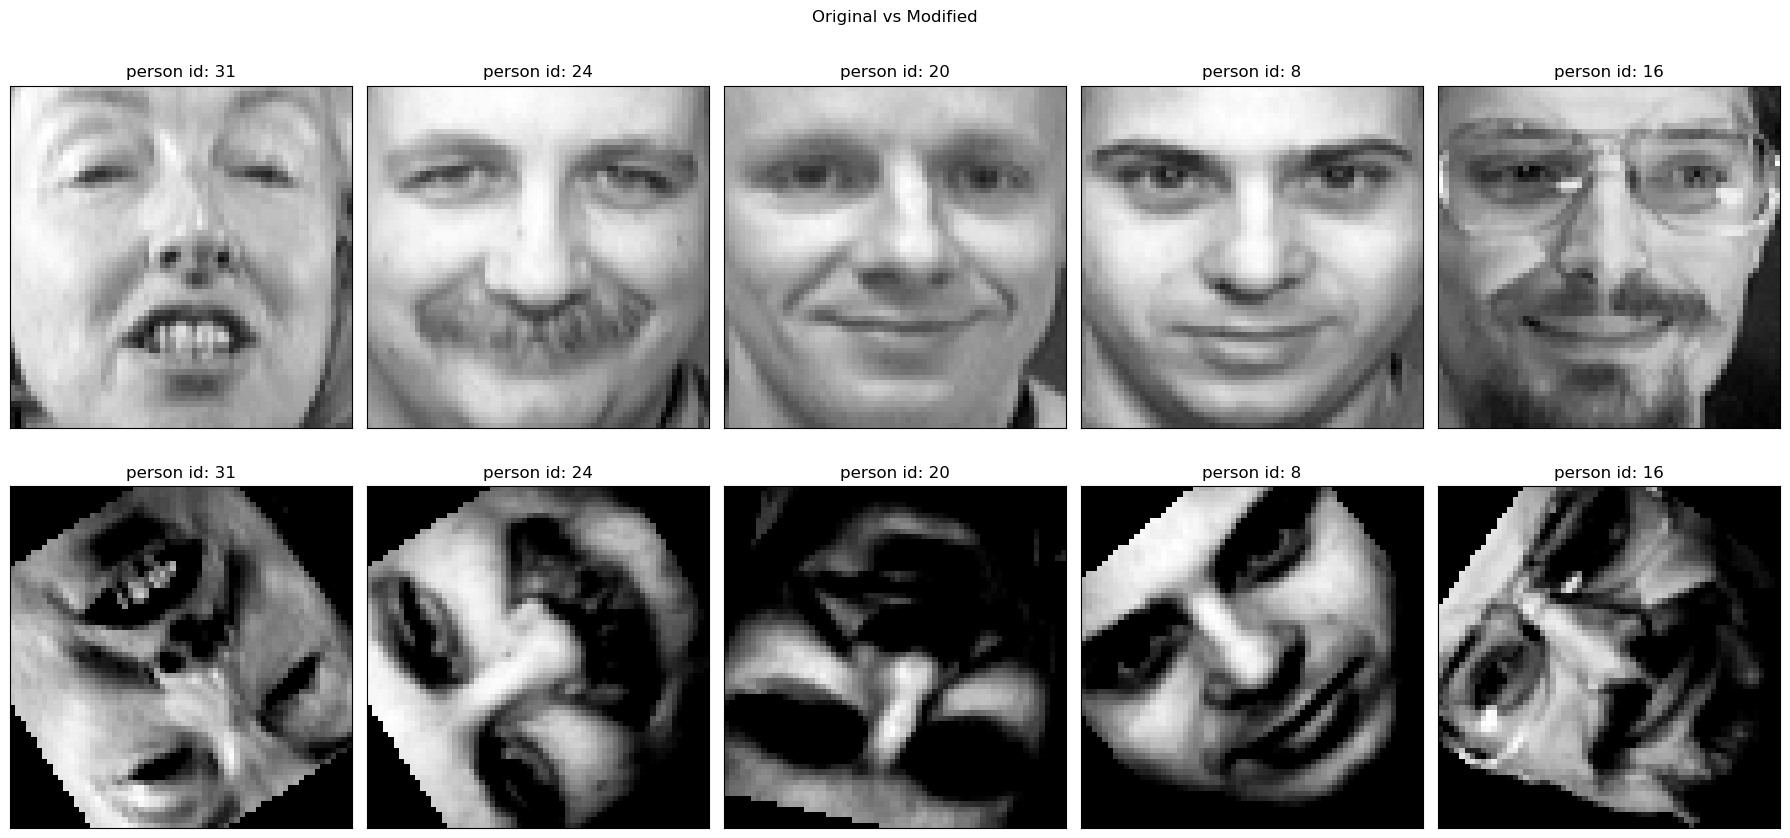

In [74]:
X_modified = []
random.seed(42) # for random angles

# Modify first 5 images in training set
for i in range(5):
    original_image = X_train[i].reshape(64, 64)

    # Rotate image (random angles between -180 and 180)
    modified_image = rotate(original_image, angle=random.randint(-180, 180), reshape=False)

    # Flip horizontally
    modified_image = np.flip(modified_image, axis=1)

    # Darken
    modified_image = modified_image - 0.45

    # Ensure values are still between 0 and 1
    modified_image = np.clip(modified_image, 0, 1)

    X_modified.append(modified_image)

# Plot unmodified vs modified
fig, axarr = plt.subplots(nrows=2, ncols=5, figsize=(18,9))
axarr = axarr.flatten()
for i in range(5):
    axarr[i].imshow(X_train[i].reshape(64, 64), cmap='gray')
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title(f"person id: {y_train[i]}")
for i in range(5, 10):
    axarr[i].imshow(X_modified[i-5], cmap='gray')
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title(f"person id: {y_train[i-5]}")
plt.suptitle("Original vs Modified")
plt.tight_layout()
plt.show()

---

## 11. Determine if the model can detect the anomalies produced in step 10 by comparing the output of the score_samples() method for normal images and for anomalies.

In [75]:
# Initialize variables
X_normals = X_train[:5]
X_anomalies = np.array(X_modified).reshape((5, 4096))
print(X_normals.shape)
print(X_anomalies.shape)

(5, 4096)
(5, 4096)


In [76]:
# Apply PCA so it fits the model
X_normals_reduced = pca.transform(X_normals)
X_anomalies_reduced = pca.transform(X_anomalies)
print(X_normals_reduced.shape)
print(X_anomalies_reduced.shape)

(5, 222)
(5, 222)


In [77]:
# Get scores
normal_scores = gm.score_samples(X_normals_reduced)
anomaly_scores = gm.score_samples(X_anomalies_reduced)

In [78]:
normal_scores

array([-53.59282301,  39.80956248,   4.87715639,  39.22914426,
       -55.00005645])

In [79]:
anomaly_scores

array([-154.90105413, -191.12466995,  -99.96972633, -160.96899787,
       -161.75091592])

seems to be able to detect the anomalies. the scores of the modified images are much lower compared to the images that are unmodified.

---